# Elliptic Covariance Outlier Detection

Z. W. Miller - Copyright 2018

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [3]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [164]:
import numpy as np
import pandas as pd
from copy import copy

class elliptic_covariance:
    
    def __init__(self, threshold=5.991): 
        """
        Uses the covariance matrix to find the eigenvalues
        and eigenvectors. Then finds an ellipse that represents
        the training data using the standard deviation. 
        The ellipse is based on the formula:
        (x/std_X)^2 + (y/std_y)^2 + (z/std_z)^2 + ... = threshold
        The threshold value will define the allowed inliers
        and their total deviation by "distance" from the mean.
        ---
        KWargs:
        threshold: how far from the mean do you want the inlier 
        surface to exist. 5.991 represents a 95% confidence interval
        from the Cumulative Chi_2 distribution.
        """
        self.threshold = threshold
        self.number_of_columns = None
        
    def fit(self, X):
        """
        Learns about the input data and stores the mean and 
        standard deviation of each column.
        ---
        In: X (features); np.array or pandas dataframe/series
        """
        X = self.convert_to_array(X)
        new_X = copy(X)
        self.number_of_columns = new_X.shape[1]
        
        self.means = np.mean(new_X, axis = 0)  
        new_X -= self.means
        cov = np.cov(new_X, rowvar = False)
        eigenvals , eigenvecs = np.linalg.eigh(cov)
        idx = np.argsort(eigenvals)[::-1]
        self.eigenvecs = eigenvecs[:,idx]
        self.eigenvals = eigenvals[idx]

            
    def predict(self, X):
        """
        For each data point, compute whether each point
        lies within the ellipsoid created by
        (x/std_X)^2 + (y/std_y)^2 + (z/std_z)^2 + ... = threshold
        This is checked by converting each point to the new reduced
        eigen space, where the ellipsoid is centered on 0
        and each direction has an axis the size of the sqrt(eigenvalue)
        The standard deviation is that sqrt(eigenvalue) since the
        eigenvalue captures the variance in along the eigenvector.
        """
        X = self.convert_to_array(X)
        new_X = copy(X)
        new_X -= self.means
        new_X = self.convert_to_pca_space(new_X)  
        new_X /= np.sqrt(self.eigenvals)
        new_X = new_X**2
        result = np.ones(X.shape[0])
        result[np.sum(new_X, axis=1) >= self.threshold] = -1
        return result
    
    def convert_to_pca_space(self, X):
        """
        Converts the points to the new eigenspace
        """
        return np.dot(X,self.eigenvecs)  
    
    def fit_predict(self, X):
        """
        Learn from X and then return the transformed version
        of X for the user to use.
        ---
        In: X (features); np.array or pandas dataframe/series
        """
        self.fit(X)
        return self.transform(X)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

In [165]:
train_data = [[0.5,0.5],[0.6,0.3],[0.5,0.4]]
ec = elliptic_covariance()
ec.fit(train_data)

In [167]:
ec.predict([[0.587142,0.48],[0.5,0.4]])

array([-1.,  1.])

## Now let's try with some more interesting data

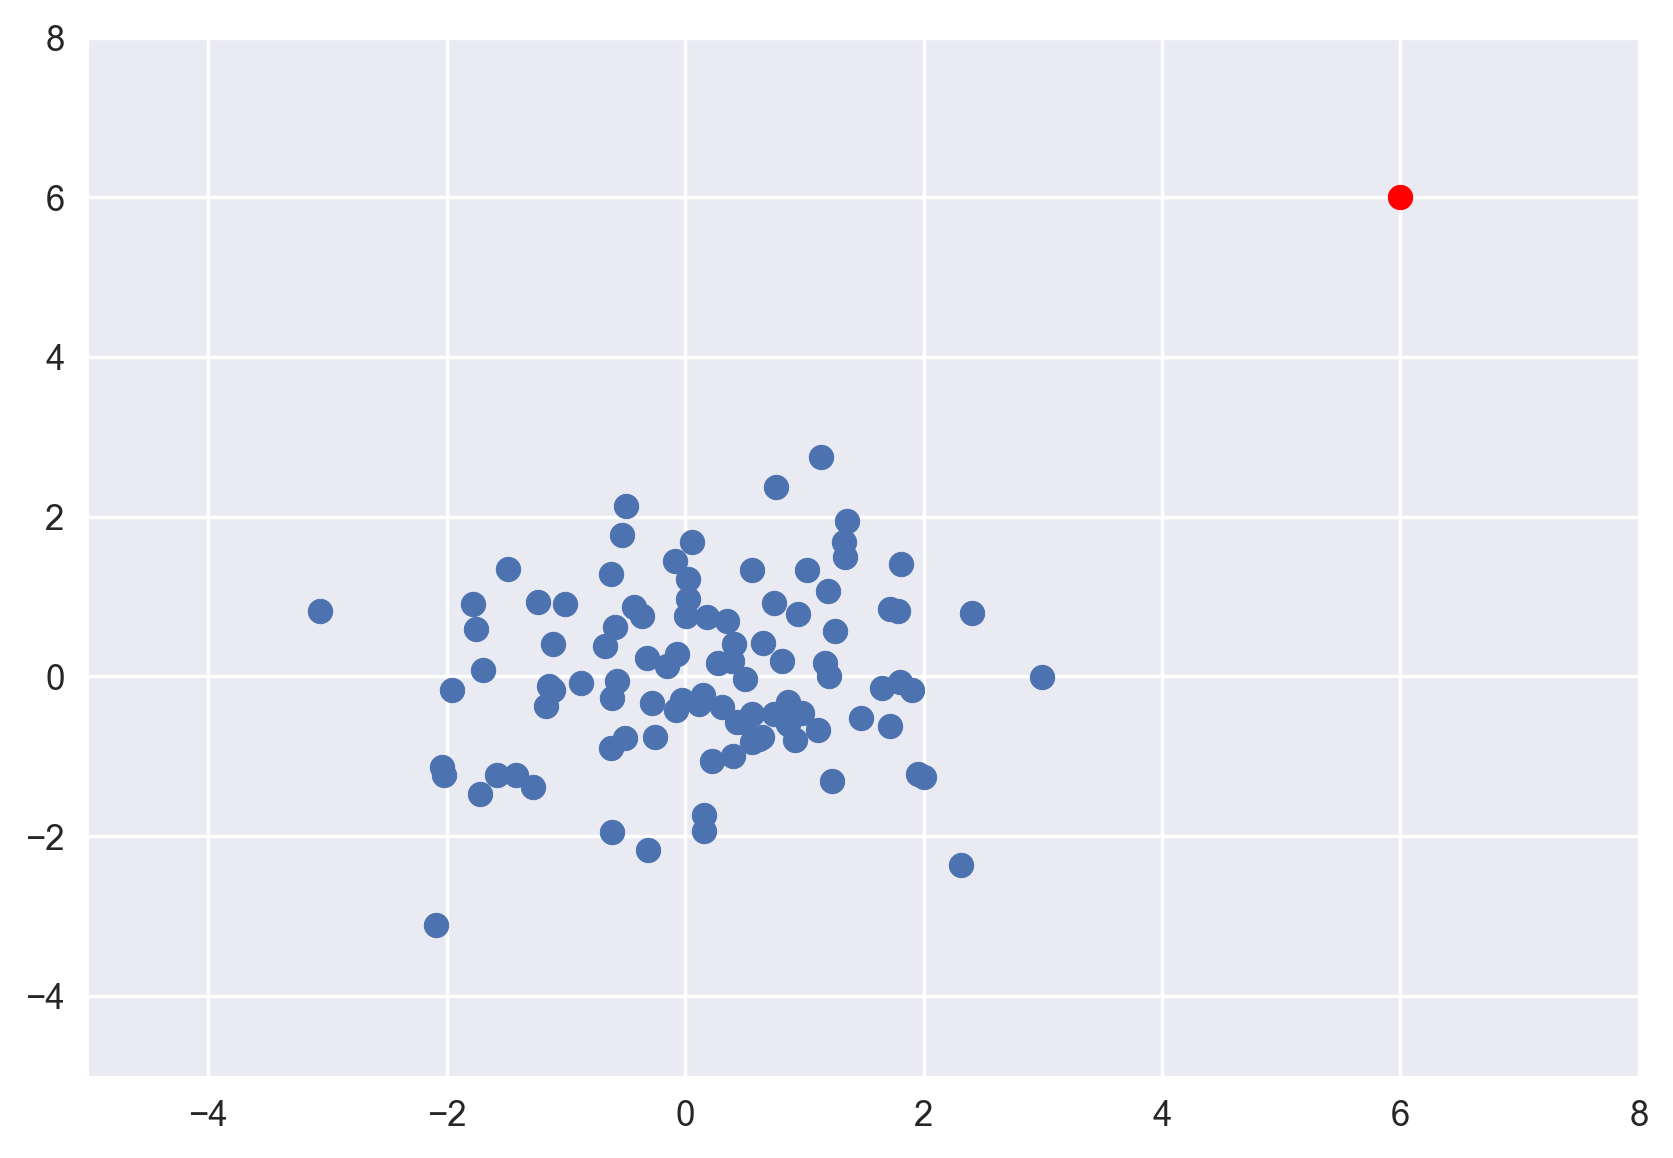

In [168]:
X = np.random.normal(0,1,size=(100,2))
outlier = np.array([6.,6.]).reshape(-1,2)
plt.figure(dpi=250)
plt.scatter(X[:,0], X[:,1])
plt.scatter(outlier[:,0], outlier[:,1],c='r')
plt.xlim(-5,8)
plt.ylim(-5,8);

In [169]:
ec = elliptic_covariance()
ec.fit(X)

In [170]:
ec.predict(X)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [171]:
ec.predict(outlier)

array([-1.])

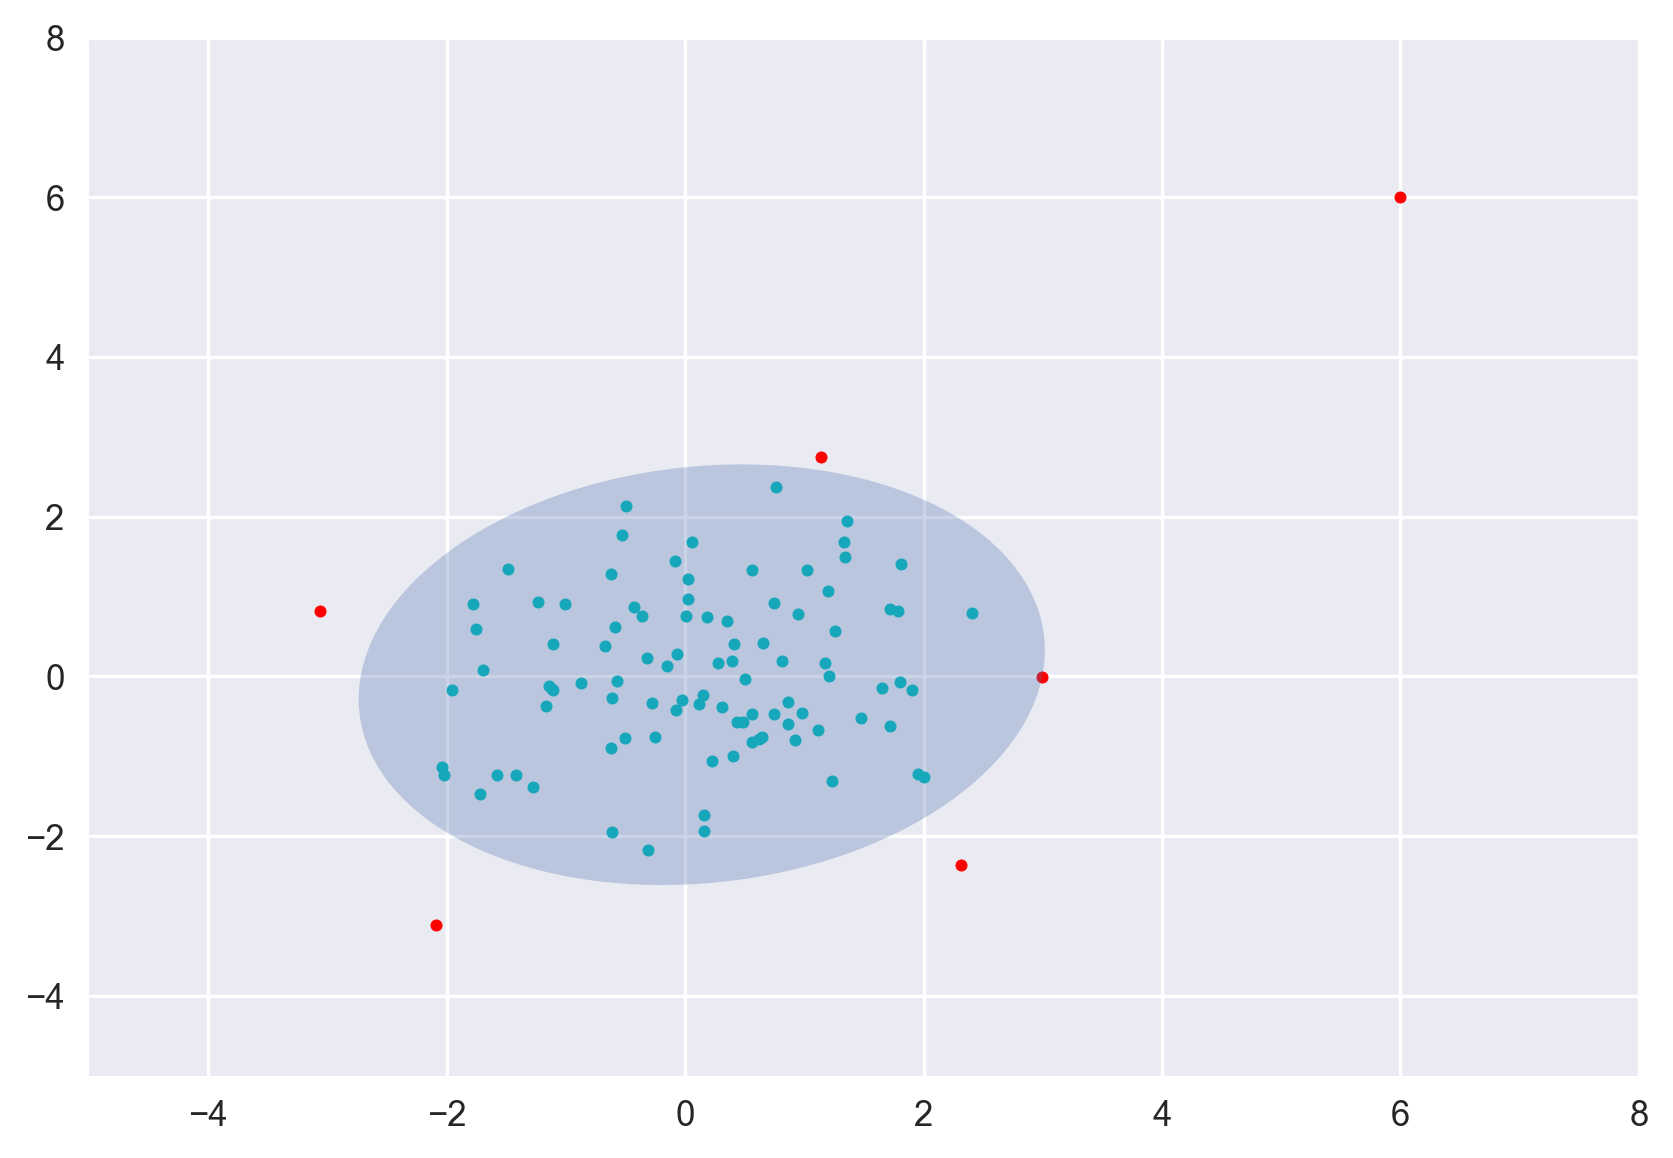

In [172]:
from matplotlib.patches import Ellipse

angle = np.arctan(ec.eigenvecs.T[0][1]/ec.eigenvecs.T[0][0]) * 180/np.pi
ell = Ellipse(ec.means, 2*np.sqrt(ec.threshold*ec.eigenvals[0]), 2*np.sqrt(ec.threshold*ec.eigenvals[1]), 
              angle=angle)
ell.set_alpha(0.3)

plt.figure(dpi=250)
for pt,label in zip(X,ec.predict(X)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c', s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10) 
        
for pt,label in zip(outlier,ec.predict(outlier)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c',s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10)  
        
plt.xlim(-5,8)
plt.ylim(-5,8)

ax = plt.gca()
ax.add_artist(ell)

## With a smaller threshold

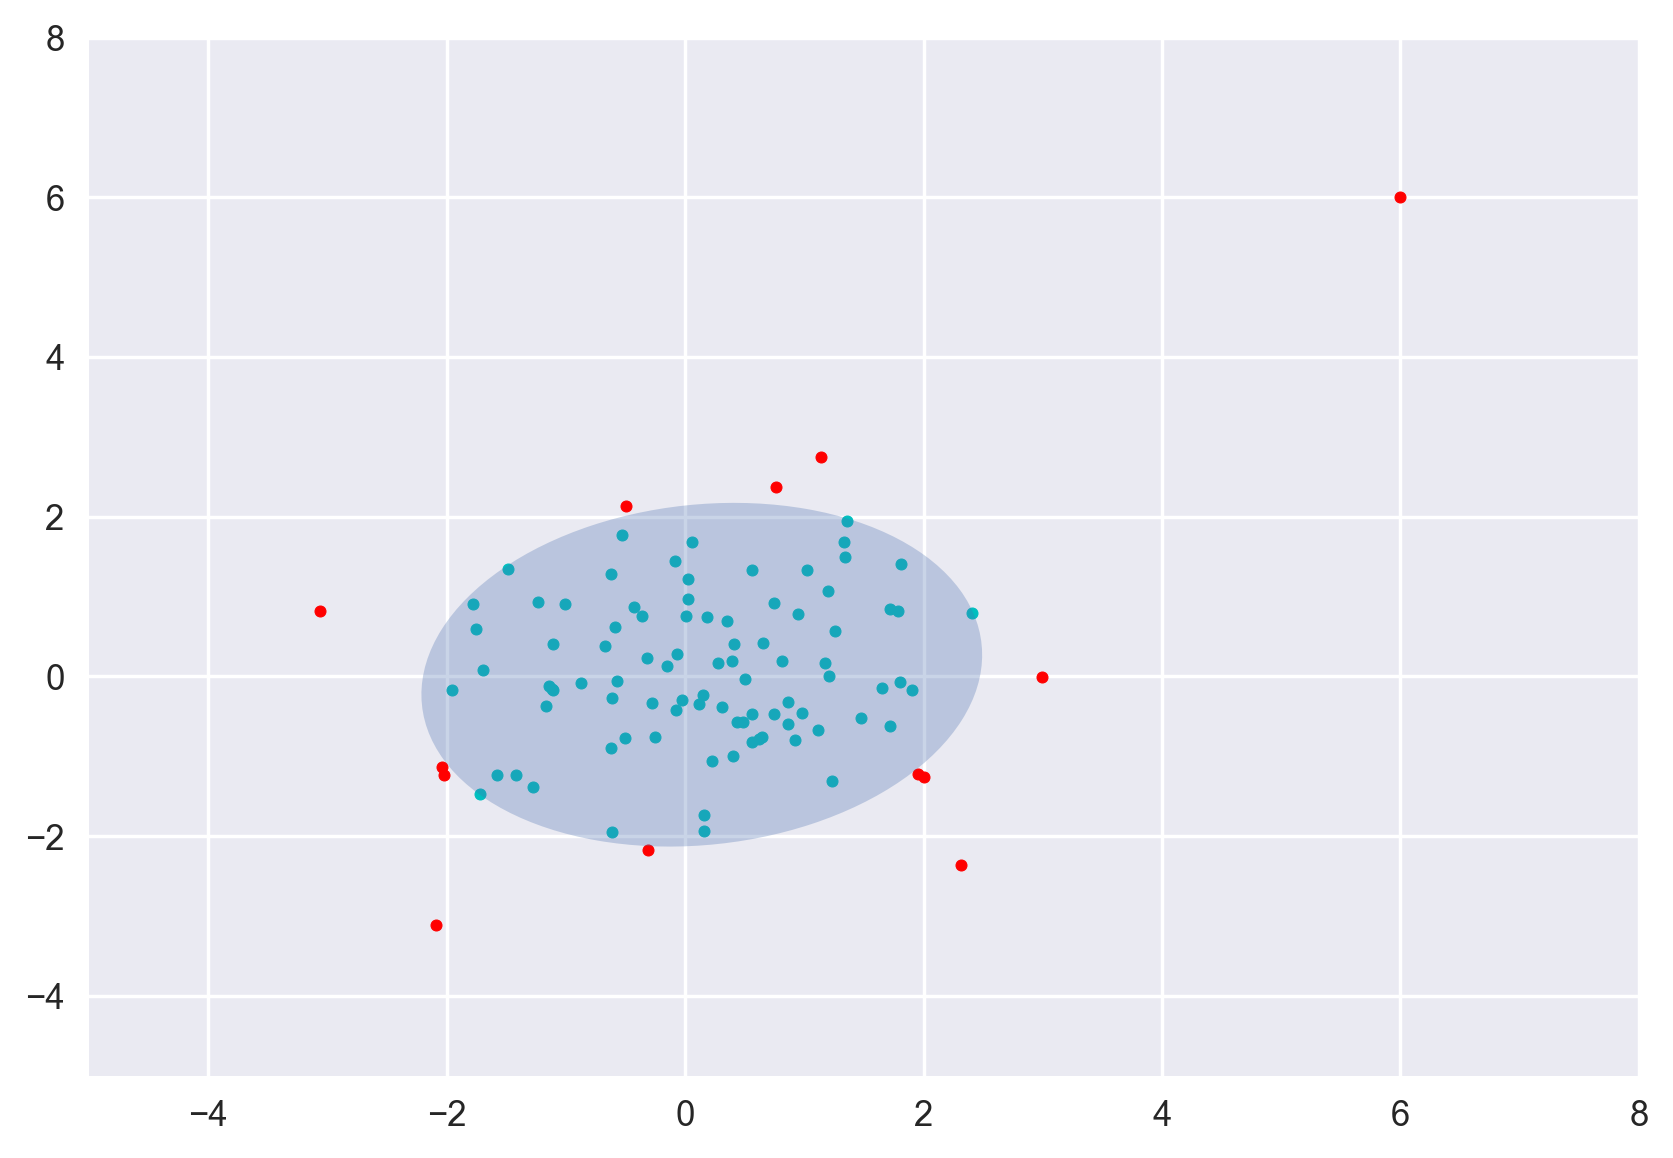

In [173]:
ec = elliptic_covariance(threshold=4)
ec.fit(X)

angle = np.arctan(ec.eigenvecs.T[0][1]/ec.eigenvecs.T[0][0]) * 180/np.pi
ell = Ellipse(ec.means, 2*np.sqrt(ec.threshold*ec.eigenvals[0]), 2*np.sqrt(ec.threshold*ec.eigenvals[1]), 
              angle=angle)
ell.set_alpha(0.3)

plt.figure(dpi=250)
for pt,label in zip(X,ec.predict(X)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c', s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10) 
        
for pt,label in zip(outlier,ec.predict(outlier)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c',s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10)  
        
plt.xlim(-5,8)
plt.ylim(-5,8)

ax = plt.gca()
ax.add_artist(ell)

# Now let's tried with some skewed data!

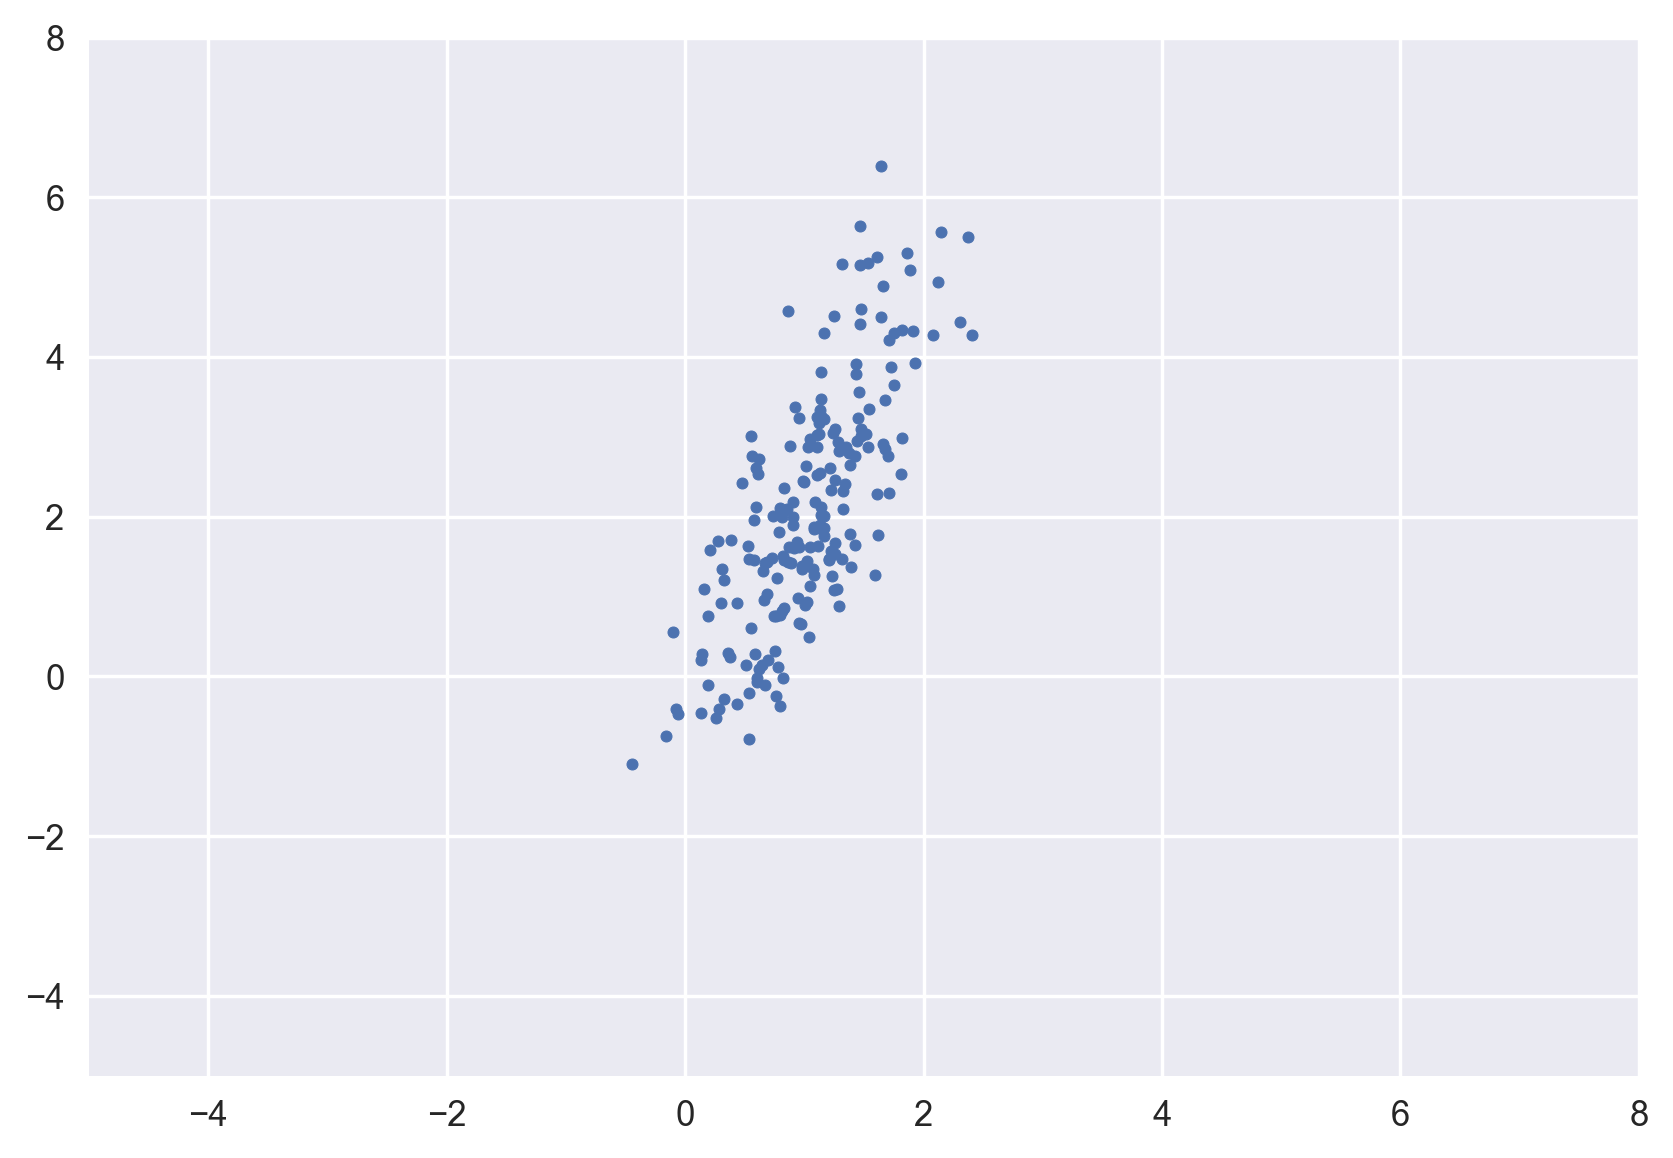

In [177]:
col1 = np.random.normal(1,0.5,size=200).reshape(-1,1)
col2 = 2*(col1+np.random.normal(0,0.5,size=200).reshape(-1,1))
X = np.hstack((col1,col2))
plt.figure(dpi=250)
plt.scatter(X[:,0],X[:,1], s=10)
plt.xlim(-5,8)
plt.ylim(-5,8);

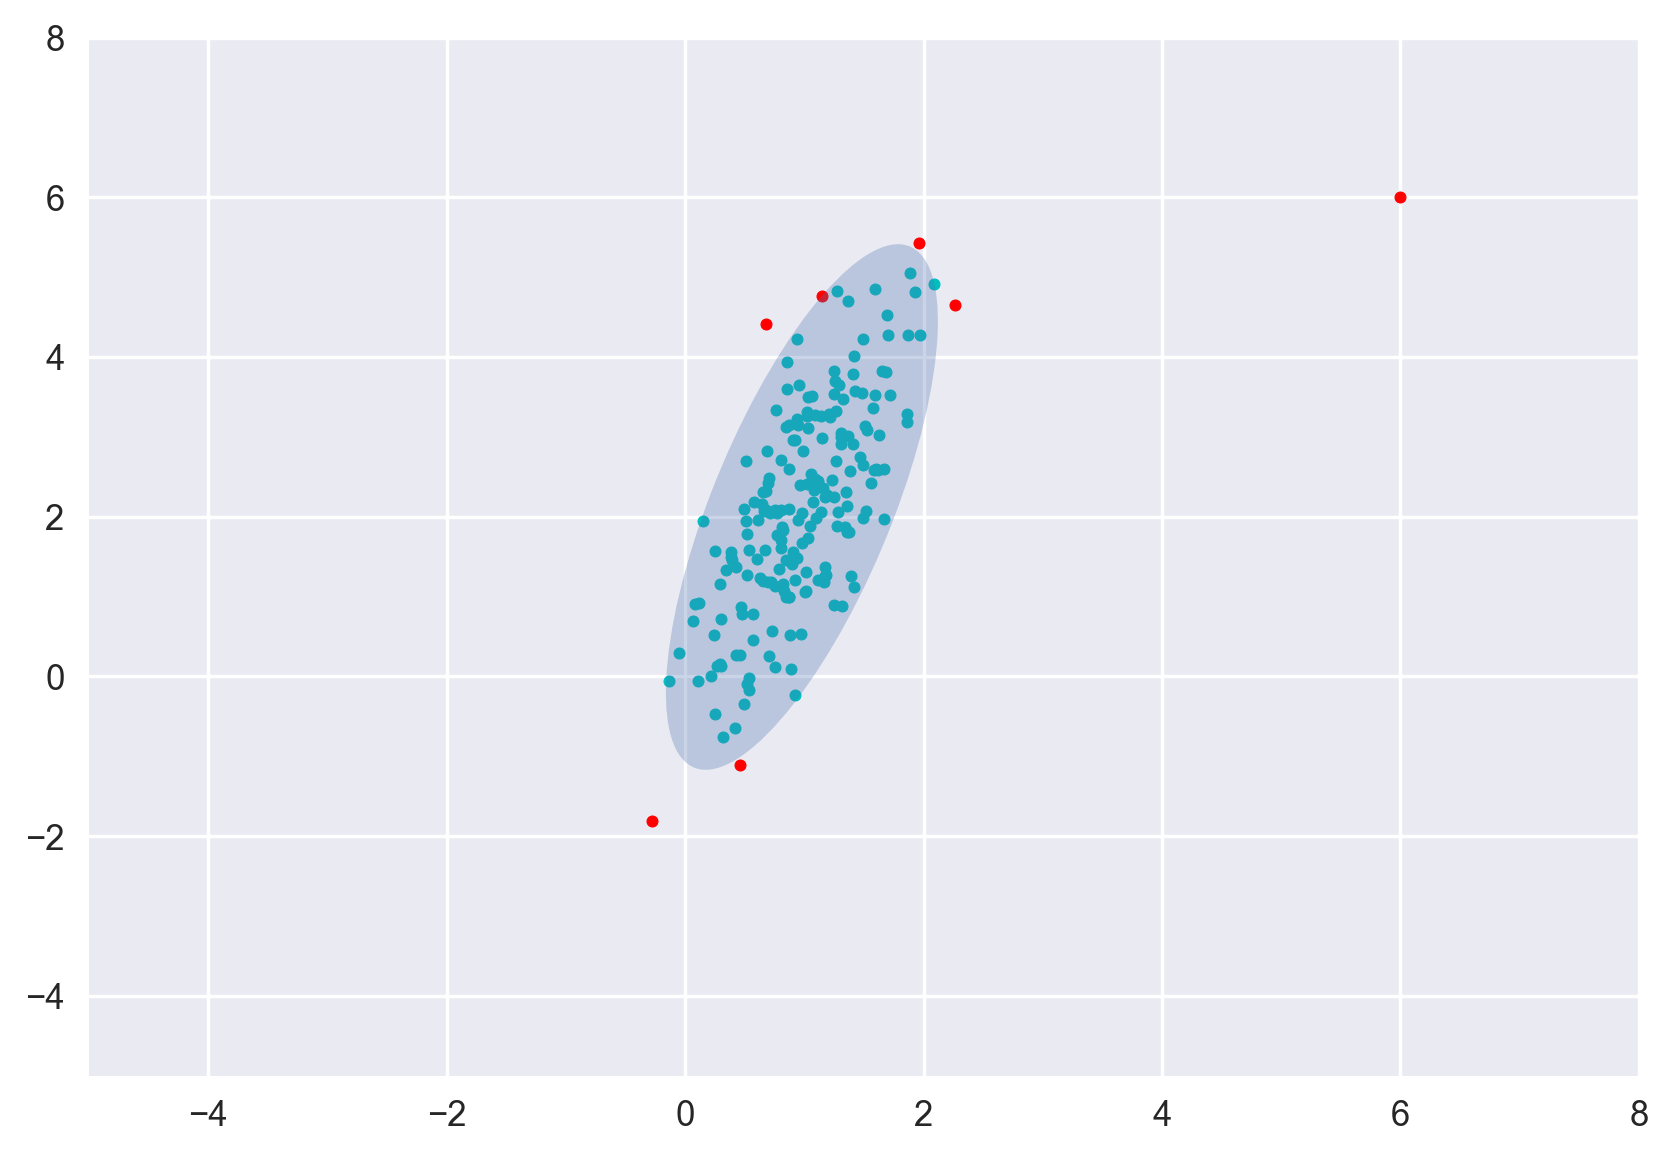

In [176]:
ec = elliptic_covariance()
ec.fit(X)

angle = np.arctan(ec.eigenvecs.T[0][1]/ec.eigenvecs.T[0][0]) * 180/np.pi
ell = Ellipse(ec.means, 2*np.sqrt(ec.threshold*ec.eigenvals[0]), 2*np.sqrt(ec.threshold*ec.eigenvals[1]), 
              angle=angle)
ell.set_alpha(0.3)

plt.figure(dpi=250)
for pt,label in zip(X,ec.predict(X)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c', s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10) 
        
for pt,label in zip(outlier,ec.predict(outlier)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c',s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10)  
        
plt.xlim(-5,8)
plt.ylim(-5,8)

ax = plt.gca()
ax.add_artist(ell);